## Coupling forest dynamics (NetLogo) with hillslope sediment transport (Landlab)
This notebook shows how a simple forest dynamics model can be coupled to Landlab components using PyNetLogo. The forest dynamics model is an Agent Based Model (ABM) developed in NetLogo. The example shows how to link this ABM with the LinearDiffuser component in Landlab 2.0. If you have the standard packages installed with the Anaconda distribution of Python 3, you will only need to check for the following additional items:<br>

1. NetLogo is installed (versions 5.2, 5.3, or 6.0 ONLY)
2. 'tree_soil_pro_simple.nlogo' is in the local directory
3. Seaborn library for data visualization is installed (https://seaborn.pydata.org/)
4. OPTIONAL: 'xy_trees_initial.xlsx' is in the local directory

_last modified by mwrossi on 06.02.2020_

In [1]:
# Import packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.components import LinearDiffuser
import pyNetLogo

%matplotlib inline

In [2]:
# Open NetLogo
# Running the headless version of NetLogo will dramatically speed up computation
netlogo = pyNetLogo.NetLogoLink(gui=False)

In [3]:
# Check version of NetLogo
# The most recent version of NetLogo (v6.1) is not supported by PyNetLogo
# Make sure your installed version is 5.2, 5.3, or 6.0
print(netlogo.netlogo_version)

6.0


## Model description
This is a simpler version of a model for soil production via tree root growth currently being developed by Matthew Rossi, Greg Tucker, Suzanne Anderson, and Bob Anderson. Variables that have been removed for the sake of demonstration are indicated by strikethrough text. This notebook is structured into three main parts:<br>

1. Running a headless version of NetLogo in Python
2. Reading variables from NetLogo to Landlab and then writing them back to NetLogo
3. Running a coupled NetLogo - Landlab model
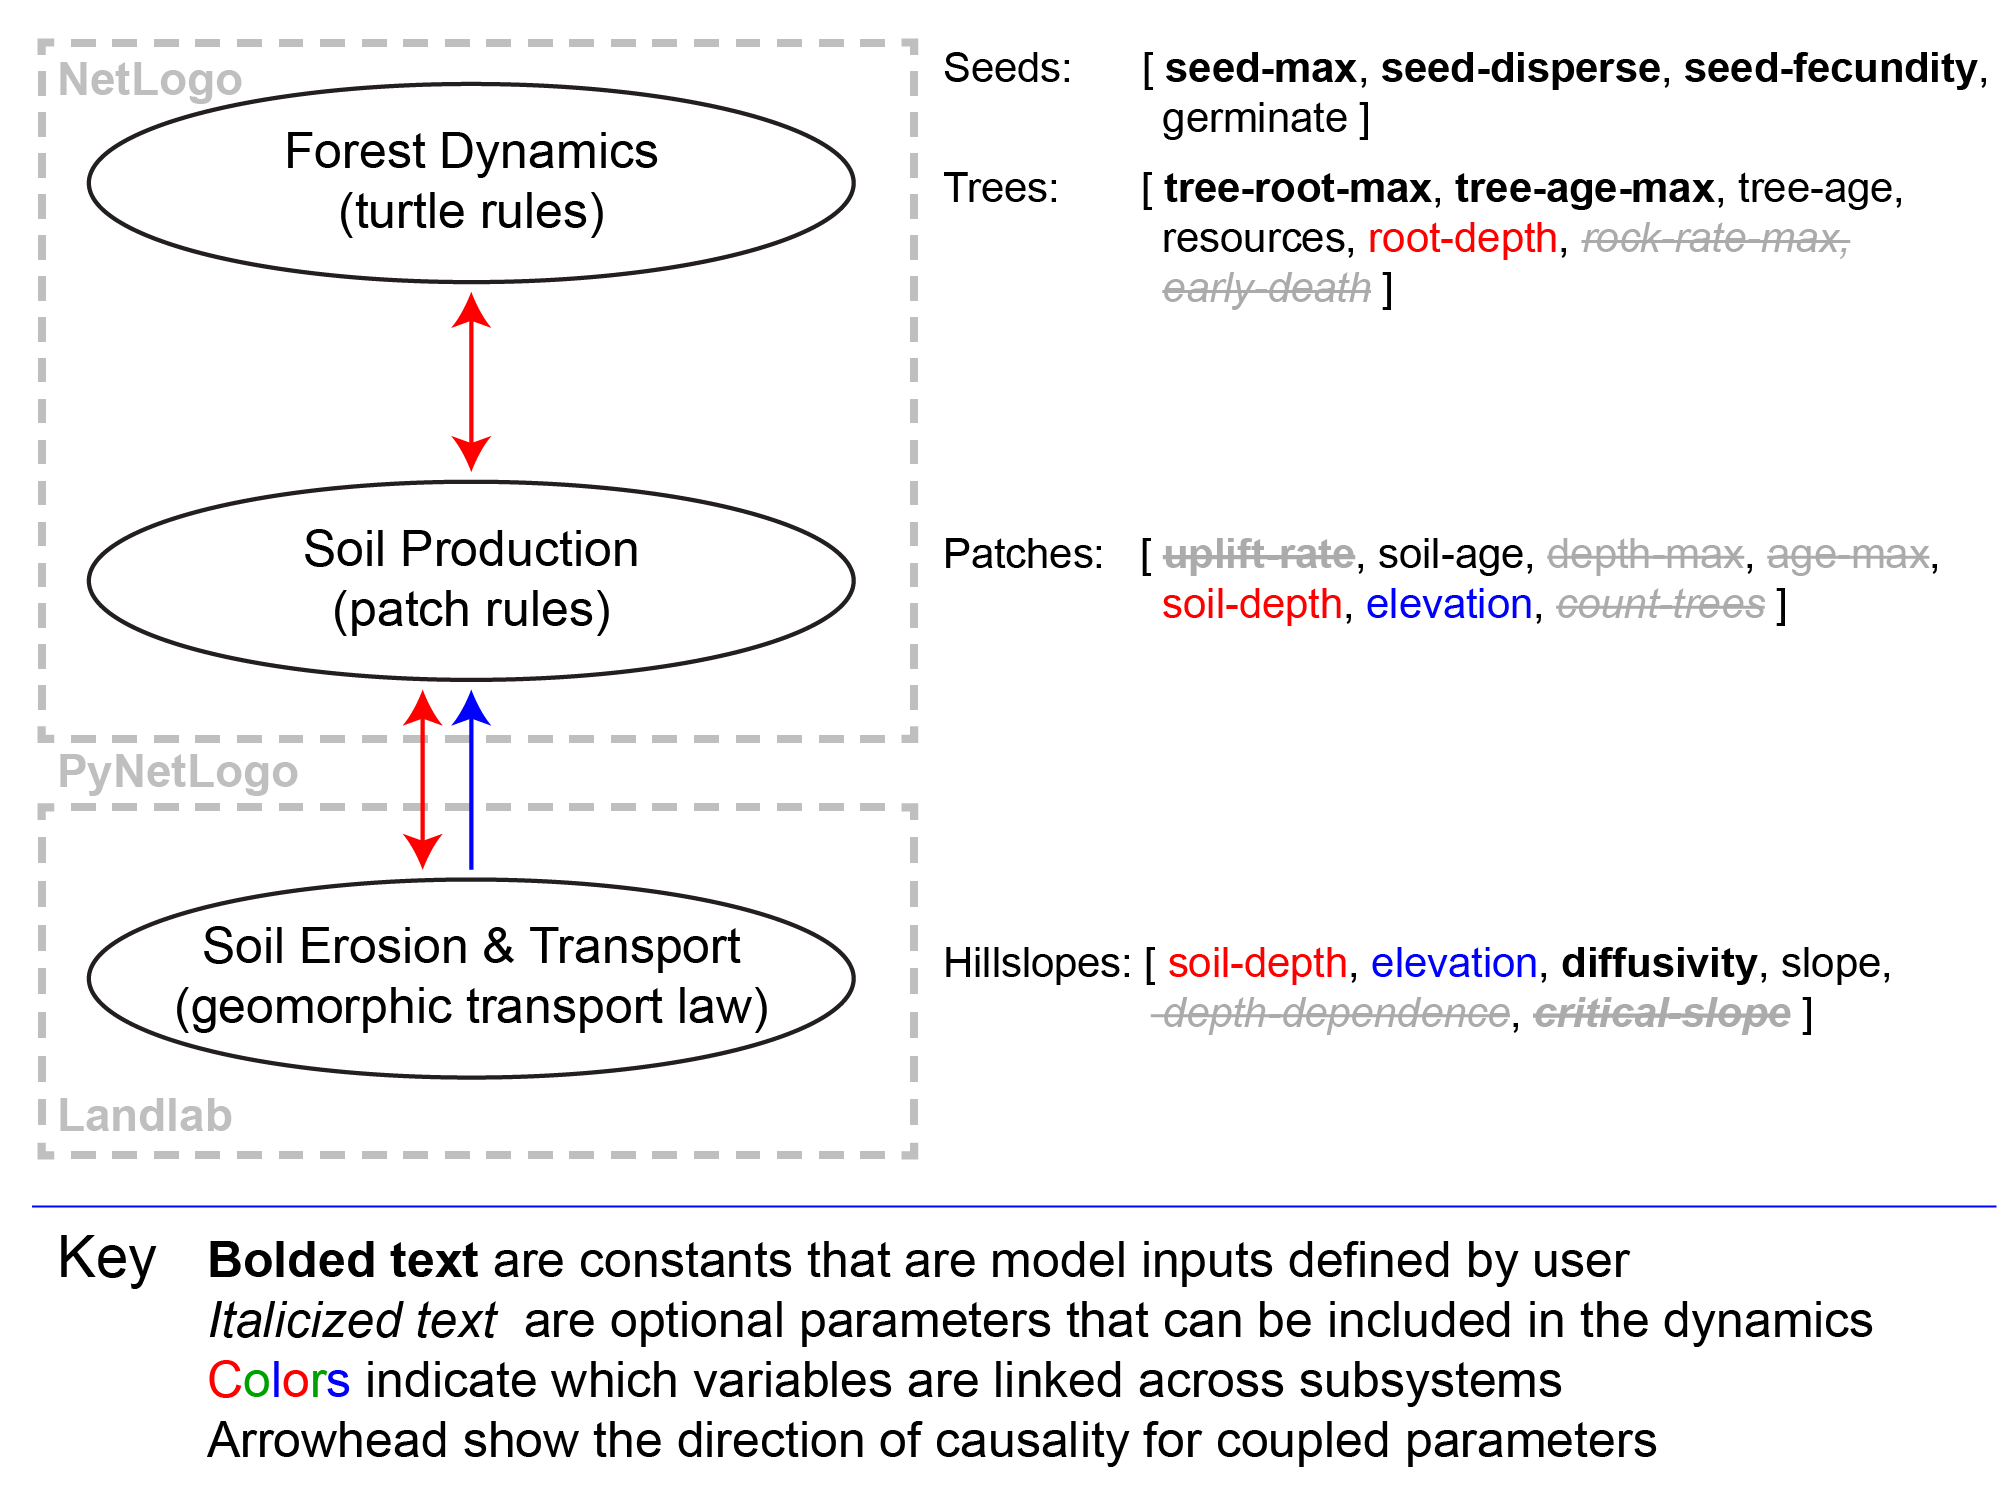

## 1 Running NetLogo from Python using pyNetLogo

In part 1, I am just going to show you how to run NetLogo in Python using the pyNetLogo interface. For documentation and tutorials see:<br>
https://pynetlogo.readthedocs.io/en/latest/

In [4]:
# Open NetLogo, load model, and setup initial conditions
netlogo.load_model('./tree_soil_pro_simple.nlogo')  # filename for NetLogo model
netlogo.command('set initial-number-trees 4')       # [1 to 20]
netlogo.command('set tree-root-max 3.0')            # [0.1 to 3.0]
netlogo.command('set tree-age-max 100')             # [1 to 200]
netlogo.command('set seed-max 5')                   # [1 to 30]
netlogo.command('set seed-disperse 5')              # [1 to 40]
netlogo.command('set seed-fecundity 0.975')         # [0.975 to 0.999]
netlogo.command('setup')

In [5]:
# OPTIONAL CELL
# Use this if you want to specify the coordinates of the initial locations of trees
# MAKE SURE initial-number-trees (n) is the same as occur in excel sheet
# Otherwise, it will only modify the positions of the first n agents
# Read in .csv file with agent xy coordinates

agent_xy = pd.read_csv('./xy_trees_initial.csv')
netlogo.write_NetLogo_attriblist(agent_xy[['who','xcor','ycor']], 'tree')
agent_xy[['who','xcor','ycor']].head()

# Note that event though this eliminates one stochastic variable in your model initialization,
# that population dynamics themselves are stochastic so you may get different results every time.

,who,xcor,ycor
0,0,18,18
1,1,18,56
2,2,56,18
3,3,56,56


## 1.1 Map out the initial condition
Whether you used the random seed in NetLogo or specified your own inital population of trees, we will now map them alongside the growth functions for the input parameters we specified above. Note that we will be using wrapping boundary conditions such that trees that lie near the edge of the spatial domain still contribute to the population dynamics. This is set in the .nlogo model itself.

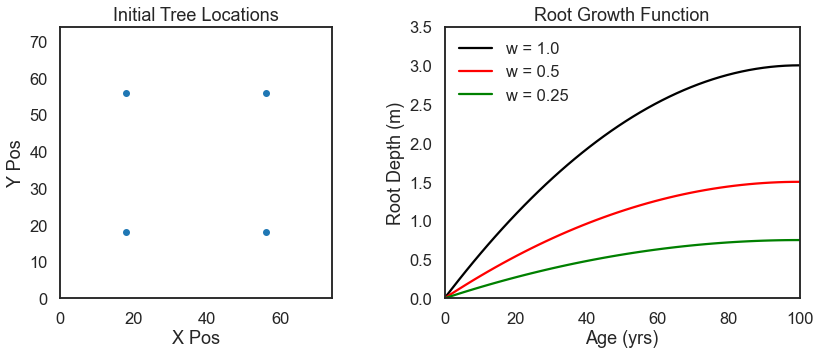

In [6]:
# Report initial location of trees
x = netlogo.report('map [s -> [xcor] of s] sort trees')
y = netlogo.report('map [s -> [ycor] of s] sort trees')

# Root growth function for input parameters (w=1)
life = netlogo.report('tree-age-max')
coef1 = netlogo.report('tree-growth-a')
coef2 = netlogo.report('tree-growth-b')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Show map of tree locations
ax1.scatter(x, y, s=30)
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Initial Tree Locations')

# Show optimum root growth trajectory
x = np.linspace(0.0, float(life), endpoint=True)
ax2.plot(x, (coef1 * (x**2)) + (coef2 * x), '-k', label='w = 1.0');
ax2.plot(x, 0.5 * ((coef1 * (x**2)) + (coef2 * x)), '-r', label='w = 0.5');
ax2.plot(x, 0.25 * ((coef1 * (x**2)) + (coef2 * x)), '-g', label='w = 0.25');
ax2.set(xlim=(0, life), ylim=(0, 3.5), xlabel='Age (yrs)', ylabel='Root Depth (m)', title='Root Growth Function')
ax2.legend(loc='upper left', frameon=False)

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

To check the intial conditions for the main variables (i.e., elevation and soil depth), let's plot them up. We could have done this many different ways, but for this example the initial topography is specified in the .nlogo model. All patches begin with zero soil initially.

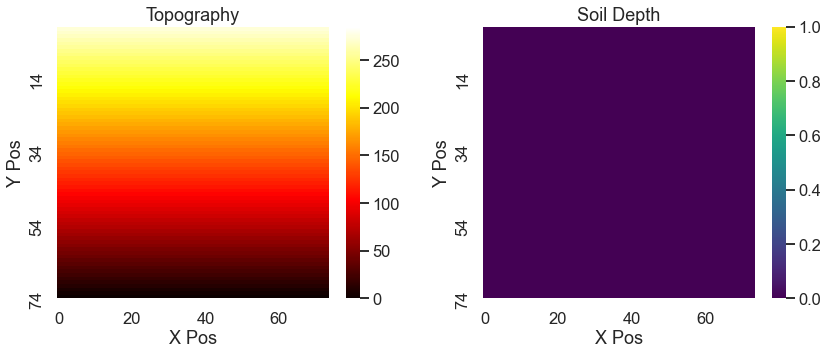

In [7]:
# Report initial topography (constant slope ~36 degrees towards southern boundary)
topo = netlogo.patch_report('elevation')

# Report initial depths of soil (should be 0 everywhere initially)
sdepths = netlogo.patch_report('soil-depth')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Show map of topography
patches = sns.heatmap(topo, vmin=0, vmax=285., xticklabels=20, yticklabels=20, ax=ax1, cmap='hot')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')

# Show map of soil depths
patches = sns.heatmap(sdepths, vmin=0., vmax=1., xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

## 1.2 Run the model
We will now run the model for 500 ticks (which are intended to represent years in the ABM) to examine how the spatial patterns of trees and soil evolve. How long this takes to run will depend on how many agents are produced for a given configuration of input parameters (for 500 ticks, less than a minute). Nevertheless, in my experience, this headless version of NetLogo runs a couple of orders of magnitude faster than operating within the gui, though I have not formally tested it.

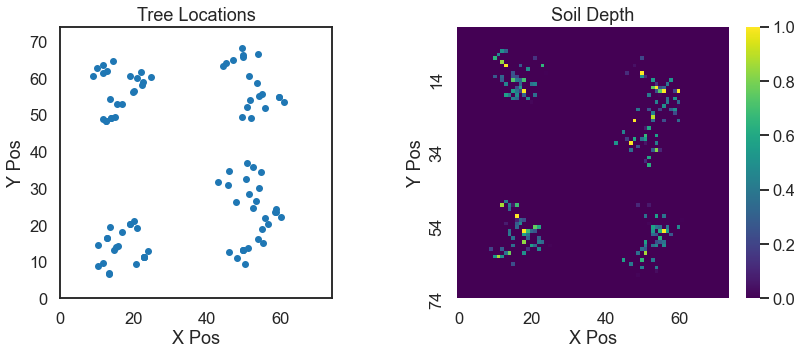

In [8]:
# Run the model forward 500 ticks
netlogo.command('repeat 500 [go]')

# Report the current location of trees
x = netlogo.report('map [s -> [xcor] of s] sort trees')
y = netlogo.report('map [s -> [ycor] of s] sort trees')

# Report initial depths of soil (should be 0 everywhere initially)
sdepths = netlogo.patch_report('soil-depth')

# Show current maps
fig, (ax1, ax2) = plt.subplots(1, 2)

# Tree locations
ax1.scatter(x, y, s=30)
ax1.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Tree Locations')

# Soil depths
patches = sns.heatmap(sdepths, vmin=0, vmax=1.0, xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

# Note that if you just keep running this cell, that you are starting from the previous model state.

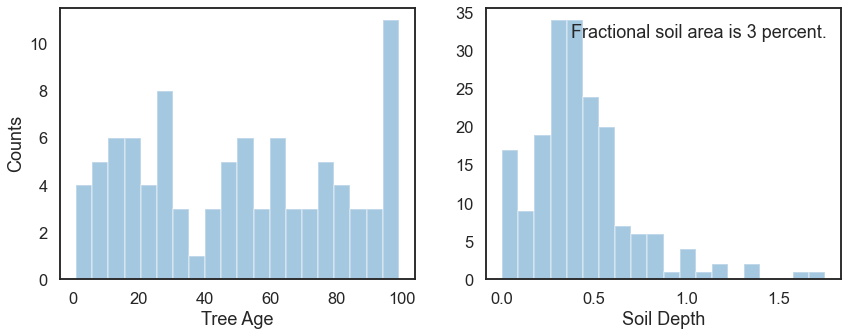

In [9]:
# Examine the tree age and soil depth distributions
# Report attributes from NetLogo
tree_ages = netlogo.report('[tree-age] of trees')
soil_depths = netlogo.report('[soil-depth] of patches with [pcolor = yellow]')
soil_frac = netlogo.report('(100 * count soil) / (76 * 76)')#' patches with [pcolor != yellow]')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Show distribution of tree ages
sns.distplot(tree_ages, kde=False, bins=20, ax=ax1, label='Tree Ages')
ax1.set_xlabel('Tree Age')
ax1.set_ylabel('Counts')

# Show distribution of soil depths
sns.distplot(soil_depths, kde=False, bins=20, ax=ax2, label='Soil Depths')
ax2.set_xlabel('Soil Depth')
result = 'Fractional soil area is %d percent.' % soil_frac
ax2.annotate(result, xy=(0.5,0.5), xytext=(0.24,0.89), textcoords='axes fraction', fontsize=18)

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

## 2 Passing variables between NetLogo and Landlab
In part 2, let's re-start the model with an eye towards passing the values for soil depth and elevation between NetLogo and Landlab. For now let's allow the forest dynamics to evolve over some timescale, pass the topography and soil grids to landlab, diffuse the landscape, and pass these results back to NetLogo.<br>

We will use the [LinearDiffuser](https://landlab.readthedocs.io/en/master/reference/components/diffusion.html) component in Landlab based on Culling (1963). We can use this same approach to test the sensitivity of results to different hillslope transport laws (e.g., depth-dependent diffusion, nonlinear diffusion), but for now we will take adavantage of the simplicity of using this one. Despite its simplicity, we will still have to treat the diffusion constant as spatially variable. We will use soil depth to set the variabilit in this coefficient.<br>

### References
Culling, W. (1963). Soil Creep and the Development of Hillside Slopes. The Journal of Geology 71(2), 127-161. https://dx.doi.org/10.1086/626891

In [10]:
# Re-initialize the NetLogo model using same configuration as above
netlogo.command('setup')

# Read in excel file with agent xy coordinates
agent_xy = pd.read_csv('./xy_trees_initial.csv')
netlogo.write_NetLogo_attriblist(agent_xy[['who','xcor','ycor']], 'tree')
  
# Setup landlab grid with boundary and initial conditions
tt = 1000        # total time
dx = 5.          # grid scale
dstar = 0.2      # depth scaling for diffusion constant

# Setup landlab grid
mg = RasterModelGrid((75, 75), xy_spacing = dx)
mg.set_closed_boundaries_at_grid_edges(True, True, True, False)

In [11]:
# Add fields to landlab grid
z = mg.add_zeros('topographic__elevation', at='node')
zp = mg.add_zeros('past__elevation', at='node')
c = mg.add_zeros('soil__cover', at='node')
d = mg.add_zeros('soil__depth', at='node')

## 2.1 Run NetLogo and send values to Landlab
We will now run NetLogo and bring the 'elevation' and 'soil-depth' data (Pandas dataframes) into a format that can be used by Landlab models grids.<br>

In [12]:
# Run the model forward in NetLogo:
go = 'repeat %d [go]' % (tt)
netlogo.command(go)

# Report elevation and pass to landlab
topo = netlogo.patch_report('elevation')
topo = topo.to_numpy()
z[:] = zp[:] = np.reshape(topo, (5625))

# Report soil depth and pass to landlab
sdepths = netlogo.patch_report('soil-depth')
sdepths = sdepths.to_numpy()
d[:] = np.reshape(sdepths, (5625))

# Set soil creep field based on soil depths [this is actually our diffusion constant]
# We are using an exponential dependence of this coefficient wrt soil depth
maxD = 0.5
c[:] = maxD * (1.0001 - np.exp( -d[:] / dstar ))

# Print average soil depth to compare later
print(np.mean(d[:]))

# Note that we have set a max diffusion coefficient of 0.5 (pretty efficient!) and a background 
# diffusion coefficient that is 10,000 time slower than this maximum value. This means that we 
# are effectively adding a (very) small source of soil production into our model that is unrelated
# tree root growth.

0.0506794815708


Now, we are ready to re-distribute some soil...

In [13]:
# Initialize diffusion component
diffuse = LinearDiffuser(mg, linear_diffusivity='soil__cover', method='simple', deposit=True)

# Diffuse landscape and calculate soil depth
zp = z                         # prior elevation equals elevation before diffusion
diffuse.run_one_step(tt)       # diffuse the surface elevation
d[:] += z[:] - zp[:]           # re-calculate the soil depth

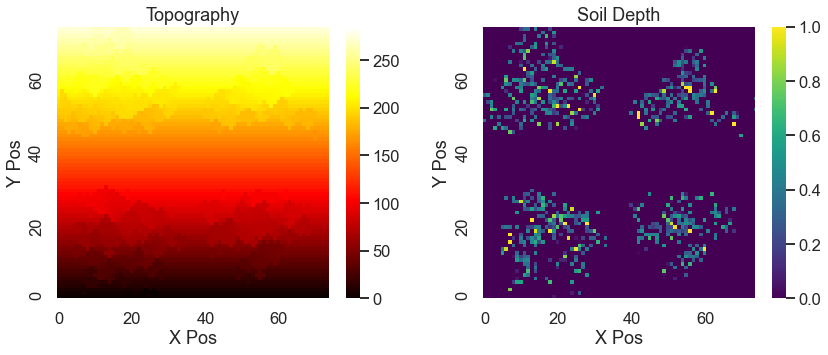

0.0506794815708


In [14]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot topography
grid = np.reshape(z, (75,75))
patches = sns.heatmap(grid, vmin=0, vmax=285, xticklabels=20, yticklabels=20, ax=ax1, cmap='hot')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')

# Plot soil depths
grid = np.reshape(d, (75,75))
patches = sns.heatmap(grid, vmin=0., vmax=1.0, xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Report the current location of trees
x = netlogo.report('map [s -> [xcor] of s] sort trees')
y = netlogo.report('map [s -> [ycor] of s] sort trees')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

# Compare this value to the one to above to see 'extra' soil being produced by not modeling soil and bedrock explicitly
print(np.mean(d[:]))

Now we can check to see how the combined effects of producing soil from tree root growth and diffusion have changed elevations with respect to the initial condition.

138.743784111


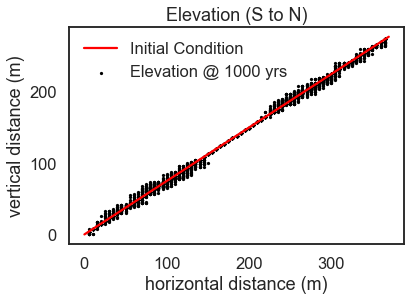

In [15]:
# Figure
fig, ax = plt.subplots(1,1)

# Pull data for each core node
x = mg.node_y[mg.core_nodes]   # N-S position
y = z[mg.core_nodes]           # elevation

# Plot data
ax.scatter(x, y, s=3, c='k', label='Elevation @ 1000 yrs')
ax.plot(mg.node_y, 0.75 * mg.node_y,'-r', label='Initial Condition')
plt.xlabel('horizontal distance (m)')
plt.ylabel('vertical distance (m)')
plt.title('Elevation (S to N)')
ax.legend(loc='upper left', frameon=False)

# Print mean elevation
# Even though locally elevations should be going up and down, the average elevation should
# be going down because the northern boundary condition is closed (initial 190 m).
print(np.mean(z[:]))

# Note that even though elevations should be going up and down locally, the average elevation should
# be going down because the northern boundary condition is closed (initial mean z = 142.5 m).

## 2.2 Send Landlab results back to NetLogo
Now that we have diffused the landscape, let's send the results back to NetLogo to run the forest dynamics models. Hopefully, we should be producing some new soil!

In [16]:
# Reformat new elevation data to send back to NetLogo
df = pd.DataFrame(data=np.reshape(z, (75,75)))
netlogo.patch_set('elevation', df)

# Reformat new soil-depth data to send back to NetLogo
df = pd.DataFrame(data=np.reshape(d, (75,75)))
netlogo.patch_set('soil-depth', df)

# Run NetLogo again
netlogo.command(go)

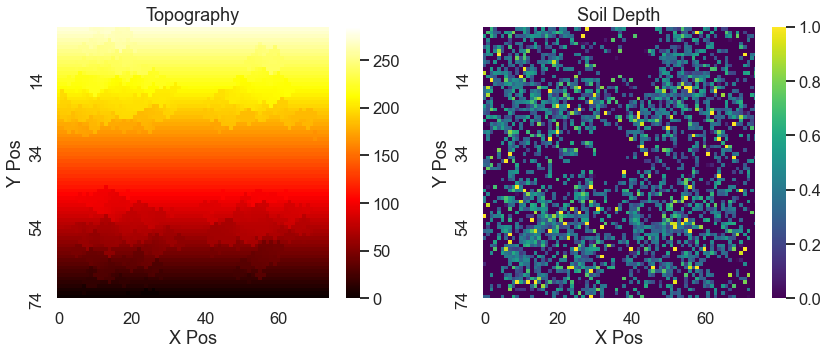

In [17]:
# Let's plot it up to see how things changed
# Report the current location of trees and soil depths
xt = netlogo.report('map [s -> [xcor] of s] sort trees')
yt = netlogo.report('map [s -> [ycor] of s] sort trees')
topo = netlogo.patch_report('elevation')
sdepths = netlogo.patch_report('soil-depth')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot topography
patches = sns.heatmap(topo, vmin=0, vmax=285, xticklabels=20, yticklabels=20, ax=ax1, cmap='hot')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')
#ax1.invert_yaxis()

# Plot soil depths
patches = sns.heatmap(sdepths, vmin=0., vmax=1., xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

# Note the topography should not have changed, because this version our NetLogo model is only modifying soil depth

## 3 Running the two-way coupled model

The time step for running the diffusion model was large with respect to changes in the forest structure. In Part 3, we apply these model components using a much shorter time step. In the procedure below, I just copy the steps from above into a for loop to  iterate between the models. Input values are the same, so let's see what the landscape would look like after 4,000 years.

In [18]:
#Inputs
tt = 4000     # total time
dt = 50       # landlab time step
dx = 5.       # grid scale
dstar = 0.5   # depth scaling for diffusion constant

# Re-initialize the NetLogo model using same configuration as above
netlogo.command('setup')

# Read in excel file with agent xy coordinates
agent_xy = pd.read_csv('./xy_trees_initial.csv')
netlogo.write_NetLogo_attriblist(agent_xy[['who','xcor','ycor']], 'tree')
  
# Setup landlab grid with GTL boundary and initial conditions
mg = RasterModelGrid((75, 75), xy_spacing = dx)
mg.set_closed_boundaries_at_grid_edges(True, True, True, False)

# Add fields to landlab grid
z = mg.add_zeros('topographic__elevation', at='node')
zp = mg.add_zeros('past__elevation', at='node')
c = mg.add_zeros('soil__cover', at='node')
d = mg.add_zeros('soil__depth', at='node')

In [19]:
# for loop that includes each of the steps from before at a step dt
# This will take a bit longer than before (up to a few minutes)
nt = int(tt // dt)

for i in range(nt):
    # Run the model forward in NetLogo:
    go = 'repeat %d [go]' % (dt)
    netlogo.command(go)
    
    # Report elevation and pass to landlab
    topo = netlogo.patch_report('elevation')
    topo = topo.to_numpy()
    z[:] = zp[:] = np.reshape(topo, (5625))
    
    # Report soil depth and pass to landlab
    sdepths = netlogo.patch_report('soil-depth')
    sdepths = sdepths.to_numpy()
    d[:] = np.reshape(sdepths, (5625))
    
    # Set soil creep field based on soil depths
    c[:] = maxD * (1.0001 - np.exp( -d[:] / dstar ))
    
    # Initialize diffusion component
    diffuse = LinearDiffuser(mg, linear_diffusivity='soil__cover', method='simple', deposit=True)
    
    # Diffuse the landscape
    zp = z
    diffuse.run_one_step(dt)
    d[:] += z[:] - zp[:]
    
    # Reformat new elevation data to send back to NetLogo
    df = pd.DataFrame(data=np.reshape(z, (75,75)))
    netlogo.patch_set('elevation', df)
    
    # Reformat new soil-depth data to send back to NetLogo
    dpass = np.reshape(d, (75,75))
    df = pd.DataFrame(data=np.reshape(d, (75,75)))
    netlogo.patch_set('soil-depth', df)
    
    # Print some time steps to make sure things are working
    if i % 10 == 0:
        print(i*dt)

0
500
1000
1500
2000
2500
3000
3500


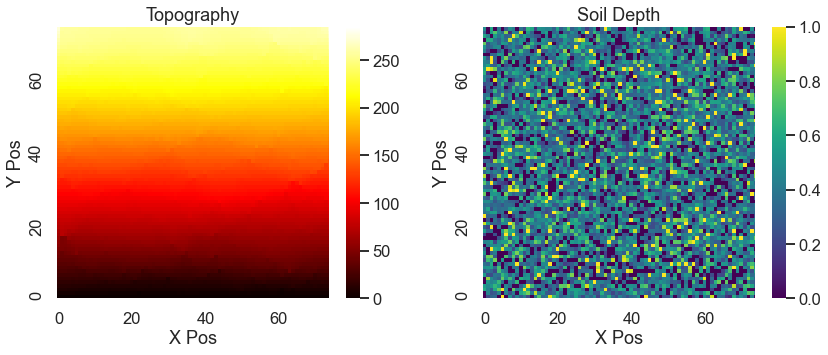

0.389593311539


In [20]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot topography
grid = np.reshape(z, (75,75))
patches = sns.heatmap(grid, vmin=0, vmax=285, xticklabels=20, yticklabels=20, ax=ax1, cmap='hot')
ax1.set(xlim=(0, 74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Topography')

# Plot soil depths
grid = np.reshape(d, (75,75))
patches = sns.heatmap(grid, vmin=0., vmax= 1., xticklabels=20, yticklabels=20, ax=ax2, cmap='viridis')
ax2.set(xlim=(0,74), ylim=(0,74), xlabel='X Pos', ylabel='Y Pos', aspect='equal', title='Soil Depth')

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

print(np.mean(d[:]))

Let's see what has happened to our elevation profile...

0.38959331153891413

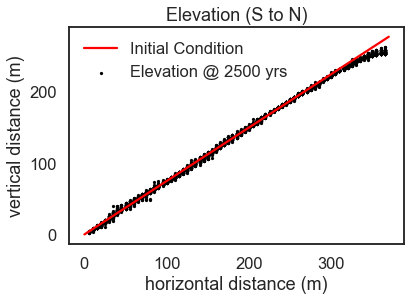

In [21]:
# Figure
fig, ax = plt.subplots(1,1)

x = mg.node_y[mg.core_nodes]
y = z[mg.core_nodes]

#elev_rast = mg.node_vector_to_raster(z)
#ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ncols = mg.number_of_node_columns
ax.scatter(x, y, s=3, c='k', label='Elevation @ 2500 yrs')
ax.plot(mg.node_y, 0.75 * mg.node_y,'-r', label='Initial Condition')

#im = plt.scatter(ycoord_rast[:, int(ncols // 2)], elev_rast[:, int(ncols // 2)])
plt.xlabel('horizontal distance (m)')
plt.ylabel('vertical distance (m)')
plt.title('Elevation (S to N)')
ax.legend(loc='upper left', frameon=False)

# Print mean elevation
np.mean(z[:])

# Note that it's a lot smoother than before and we are even starting to see convex divide up high.

And our soil depth distribution...

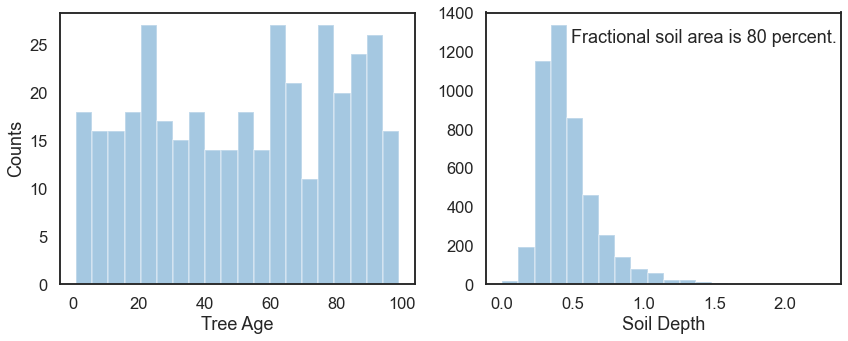

In [22]:
# Report agen attributes from NetLogo
tree_ages = netlogo.report('[tree-age] of trees')
soil_depths = netlogo.report('[soil-depth] of patches with [pcolor = yellow]')
soil_frac = netlogo.report('100 * count soil / (76 * 76)')#' patches with [pcolor != yellow]')

# Figure
fig, (ax1, ax2) = plt.subplots(1, 2)

# Show distribution of tree ages
sns.distplot(tree_ages, kde=False, bins=20, ax=ax1, label='Tree Ages')
ax1.set_xlabel('Tree Age')
ax1.set_ylabel('Counts')

# Show distribution of soil depths
sns.distplot(soil_depths, kde=False, bins=20, ax=ax2, label='Soil Depths')
ax2.set_xlabel('Soil Depth')
result = 'Fractional soil area is %d percent.' % soil_frac
ax2.annotate(result, xy=(0.5,0.5), xytext=(0.24,0.89), textcoords='axes fraction', fontsize=18)

# Size and show plots
fig.set_size_inches(14,5)
plt.show()

In [23]:
# Good idea to kill the workspace after you are done
netlogo.kill_workspace()